In [1]:
import pickle
import numpy as np
import random
import tensorflow as tf
import csv
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

/home/vrtcuser/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vrtcuser/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vrtcuser/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vrtcuser/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
def preprocess_image(images, measurements, to_flip = 0):
    X_train, y_train = images, measurements
    if to_flip == 1:
        flip_measurements = -1.0*measurements
        flip_images = []
        for image in images:
            flip_images += [cv2.flip(image, 1)]
        X_train = np.concatenate((X_train, flip_images), axis = 0)
        y_train = np.concatenate((y_train, flip_measurements), axis = 0)
    return X_train, y_train

In [4]:
def generator(samples, batch_size = 32, is_validation = 0, include_side = 0, to_flip = 0):
    samples = random.sample(samples, k=2000) if is_validation == 0 else shuffle(samples)
    num_samples = len(samples)
    while  True:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            center_images, left_images, right_images = [], [], []
            center_measurements = []
            for batch_sample in batch_samples:
                center_images += [cv2.imread('./data/'+batch_sample[0])]
                center_measurements += [float(batch_sample[3])]
                if include_side == 1:
                    left_images += [cv2.imread('./data/'+batch_sample[1].split(' ')[-1])]
                    right_images += [cv2.imread('./data/'+batch_sample[2].split(' ')[-1])]
            images = np.array(center_images)
            measurements = np.array(center_measurements)
            if include_side == 1:
                images = np.concatenate((images, left_images, right_images), axis = 0)
                measurements = np.concatenate((measurements, measurements + 0.2, measurements - 0.2), axis = 0)
            if is_validation == 0:
                X_train, y_train = preprocess_image(images, measurements, to_flip = to_flip)
            else:
                X_train, y_train = images, measurements
            yield shuffle(X_train, y_train)

In [5]:
def model_nvidia(train_samples, validation_samples):
    batch_size = 32
    train_generator = generator(train_samples, batch_size = batch_size, is_validation = 0, include_side = 1, to_flip = 0)
    validation_generator = generator(validation_samples, batch_size = batch_size, is_validation = 1, include_side = 0)
    
    model = Sequential()
    model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    model.add(Conv2D(24, 5, strides = (2,2), activation='relu'))
    model.add(Conv2D(36, 5, strides = (2,2), activation='relu'))
    model.add(Conv2D(48, 5, strides = (2,2), activation='relu'))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.fit_generator(train_generator, 
                        steps_per_epoch = 2000//batch_size, 
                        validation_data = validation_generator, 
                        validation_steps = len(validation_samples)//batch_size, 
                        epochs = 8, verbose = 1)
    model.save('model_nvidia.h5')

In [18]:
def make_uniform(samples):
    no_bins = 25
    augmented_samples = []
    count_thresh = int(len(samples)/no_bins)*2
    samples_arr = np.array(samples)
    angles = np.array(list(map(float, samples_arr[:,3])))
    angle_bins = np.linspace(-1., 1.01, no_bins + 1)
    fig, ax = plt.subplots(2)
    ax[0].hist(angles, angle_bins, rwidth = 0.9)
    print(len(angles))
    for i in range(no_bins):
        idx = np.where((angles>=angle_bins[i]) & (angles<angle_bins[i+1]))[0]
        if len(idx) < count_thresh and len(idx) > 0:
            idx_sel = np.random.choice(idx, count_thresh - len(idx))
            samples = samples + samples_arr[idx_sel].tolist()
    samples_arr = np.array(samples)
    angles = np.array(list(map(float, samples_arr[:,3])))
    print(len(angles))
    ax[1].hist(angles, angle_bins, rwidth = 0.9)
    
    for a in ax.flat:
        a.set(xlabel='Steering Angle Bins', ylabel='Images per Bin')
    
    for a in ax.flat:
        a.label_outer()

    return samples

In [45]:
def visualize_preprocess(samples):
    index = np.random.randint(0, len(samples)-1)
    images = [cv2.imread('./data/'+samples[index][i].split(' ')[-1]) for i in range(3)]
    images = [cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) for i in range(3)]
    
    img_arr = np.copy(images)
    img_arr = img_arr[[1,0,2]]
    fig, axarr = plt.subplots(1,3)
    labels = ['left', 'center', 'right']
    for i in range(3):
        axarr[i].imshow(img_arr[i])
        axarr[i].set_xlabel(labels[i])
    
    fig2, axarr2 = plt.subplots(2,1)
    img_arr2 = [cv2.flip(img_arr[1], 1), img_arr[1][75:len(img_arr[i])-25,:]]
    labels2 = ['center_flip', 'center_crop']
    for i in range(2):
        axarr2[i].imshow(img_arr2[i])
        axarr2[i].set_xlabel(labels2[i])

In [46]:
def train_model():
    samples = []
    with open('./data/driving_log.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            if line[0] == 'center':
                continue
            samples += [line]
    samples = make_uniform(samples)
    visualize_preprocess(samples)

#     train_samples, validation_samples = train_test_split(samples, test_size = 0.2)

#     model_nvidia(train_samples, validation_samples)

8036
18394


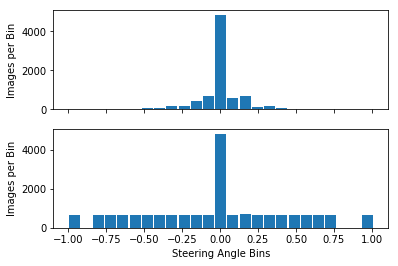

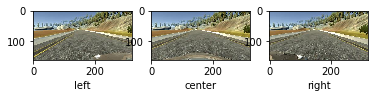

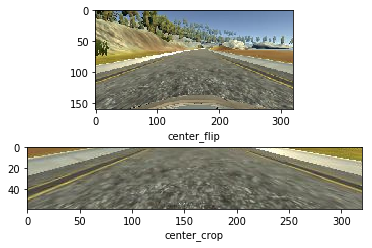

In [47]:
train_model()